In [ ]:
num_epoch = 500      
learning_rate = 0.002
batch_size = 1000

hidden_size = 16 #number of features in hidden state
num_layers = 3  #number of stacked lstm layers
bidirectional = True
drop_out = 0
bidirectional_forward_backward = 2 if bidirectional else 1

input_size = 41 #number of features
num_classes_attack_cat = 10 #number of output classes 
num_classes_label = 2       #number of output classes 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.autograd import Variable 

# GPU OR CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [ ]:
class Fake_Real_DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,data_set_path1,data_set_path2):
        df1 = pd.read_csv(data_set_path1)

        # preprocceing
        df1.drop(["label"], axis=1, inplace=True)

        #----------------------
        df2 = pd.read_csv(data_set_path2)
        
        # preprocceing
        df2.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df2[cols] = df2[cols].apply(LabelEncoder().fit_transform)

        df_all_rows = pd.concat([df1, df2])

        self.data_array = df_all_rows.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

class Fake_Real_DataSet_UNSWNB15_label(Dataset):

    def __init__(self,data_set_path1,data_set_path2):
        df1 = pd.read_csv(data_set_path1)

        # preprocceing
        df1.drop(["attack_cat"], axis=1, inplace=True)

        #----------------------
        df2 = pd.read_csv(data_set_path2)
        
        # preprocceing
        df2.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)        
        cols = ['proto' ,'state']
        df2[cols] = df2[cols].apply(LabelEncoder().fit_transform)

        df_all_rows = pd.concat([df1, df2])

        self.data_array = df_all_rows.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

class DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        print(df.attack_cat.value_counts().sort_values().plot(kind = "barh"))
        print(df['attack_cat'].value_counts())

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)
        print(df['attack_cat'].value_counts())

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

        
class DataSet_UNSWNB15_label(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        print(df.label.value_counts().sort_values().plot(kind = "pie"))

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)
        cols = ['proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

AxesSubplot(0.125,0.125;0.775x0.755)
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64
6    93000
5    58871
3    44525
4    24246
2    16353
7    13987
0     2677
1     2329
8     1511
9      174
Name: attack_cat, dtype: int64


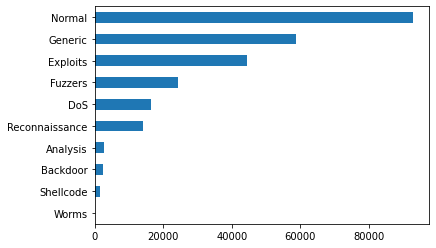

In [ ]:
dataset_attack_cat = DataSet_UNSWNB15_attack_cat("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

train_attack_cat_dataloader = DataLoader(dataset=train_attack_cat ,batch_size=batch_size ,shuffle=True)
test_attack_cat_dataloader = DataLoader(dataset=test_attack_cat ,batch_size=batch_size ,shuffle=True)

AxesSubplot(0.260833,0.125;0.503333x0.755)


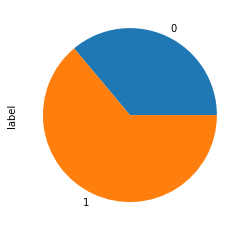

In [ ]:
dataset_label = DataSet_UNSWNB15_label("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_label)*0.3)
number_of_train = len(dataset_label) - int(len(dataset_label)*0.3)
train_label ,test_label = random_split(dataset=dataset_label, lengths=[number_of_train,number_of_test])

train_label_dataloader = DataLoader(dataset=train_label ,batch_size=batch_size ,shuffle=True)
test_label_dataloader = DataLoader(dataset=test_label ,batch_size=batch_size ,shuffle=True)

# **preprocessing ended**

# **create model**

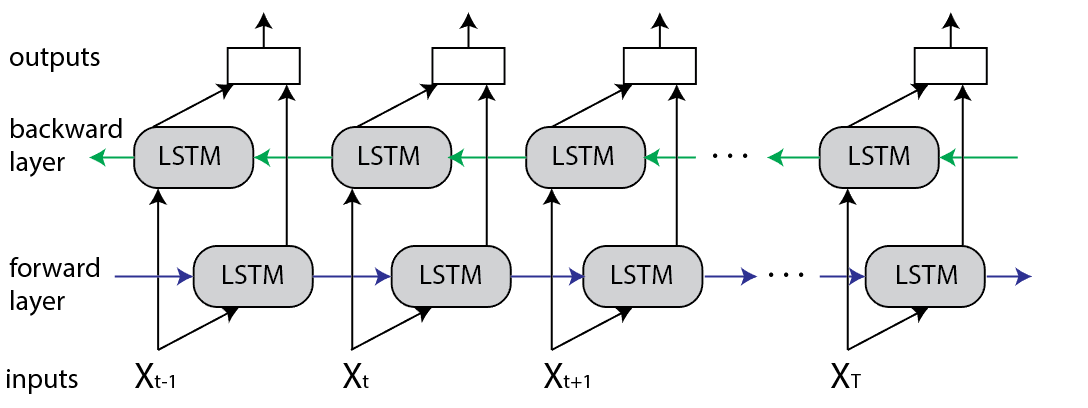

In [ ]:
class LSTM_Model_attack(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_Model_attack, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True,
                            bidirectional=bidirectional, dropout=drop_out) #lstm

        self.fc = nn.Linear(hidden_size * bidirectional_forward_backward, num_classes) #fully connected last layer
                             # 2 => forward and backward for bidirectional
    
    def forward(self,x):
                                                # 2 => forward and backward for bidirectional
        h_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #internal state

        out, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :]) 
        return out


class LSTM_Model_label(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_Model_label, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, 
                            bidirectional=bidirectional, dropout=drop_out) #lstm

        self.fc = nn.Linear(hidden_size * bidirectional_forward_backward, num_classes) #fully connected last layer

    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #internal state

        out, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :]) 
        return out


In [ ]:
my_model_attack = LSTM_Model_attack(num_classes_attack_cat, input_size, hidden_size, num_layers).to(device=device)
my_model_attack

LSTM_Model_attack(
  (lstm): LSTM(41, 16, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
my_model_attack.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.0874,  0.0329,  0.1656,  ..., -0.2100,  0.0423, -0.1484],
                      [ 0.0521, -0.2451, -0.1576,  ..., -0.0942,  0.0618, -0.1335],
                      [ 0.2243, -0.2233,  0.1480,  ...,  0.0353, -0.1245,  0.0245],
                      ...,
                      [ 0.0255, -0.1743, -0.0447,  ..., -0.2006, -0.2159, -0.1908],
                      [-0.1483,  0.0684,  0.0883,  ...,  0.1314,  0.0772,  0.0387],
                      [ 0.0275, -0.2424,  0.0092,  ..., -0.0503, -0.1650, -0.1742]],
                     device='cuda:0')),
             ('lstm.weight_hh_l0',
              tensor([[ 0.0414, -0.0310,  0.0704,  ..., -0.0471, -0.0253, -0.0551],
                      [ 0.0924, -0.1937, -0.1334,  ..., -0.1406,  0.1324, -0.1083],
                      [ 0.1190,  0.1694,  0.0048,  ..., -0.2279,  0.1110, -0.1136],
                      ...,
                      [ 0.1921,  0.0143, -0.2009,  ..., -0.0797, -0.1991,  0.05

In [ ]:
my_model_label = LSTM_Model_label(num_classes_label, input_size, hidden_size, num_layers).to(device=device)
my_model_label

LSTM_Model_label(
  (lstm): LSTM(41, 16, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

# **optimizer and loss function**

In [ ]:
loss_fn1 = nn.CrossEntropyLoss().to(device=device)
loss_fn2 = nn.CrossEntropyLoss().to(device=device)
optimizer1 = opt.Adam(params=my_model_attack.parameters(),lr=learning_rate)
optimizer2 = opt.Adam(params=my_model_label.parameters(),lr=learning_rate)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# **train attack cat**

Epoch: 0, loss: 0.7791
Epoch: 50, loss: 0.4383
Epoch: 100, loss: 0.4752
Epoch: 150, loss: 0.4574
Epoch: 200, loss: 0.4021
Epoch: 250, loss: 0.3683
Epoch: 300, loss: 0.3931
Epoch: 350, loss: 0.3753
Epoch: 400, loss: 0.4885
Epoch: 450, loss: 0.4021
Epoch: 500, loss: 0.3981
Execution Time : 1291177.7500


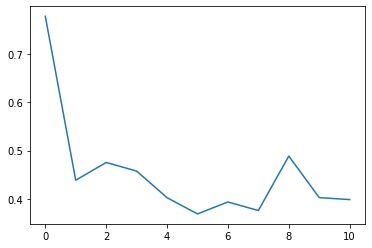

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

loss_plot = list()

for epoch in range(num_epoch+1):

    for batch_x, batch_y in train_attack_cat_dataloader:

        batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors
        
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer1.zero_grad()
        loss1 = loss_fn1(my_model_attack(batch_x) , batch_y)
        loss1.backward() 
        optimizer1.step()

    if epoch % 50 == 0:
         print("Epoch: %d, loss: %.4f" % (epoch, loss1.item()))
         loss_plot.append(loss1.item())         

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print("Execution Time : %.4f" % (start.elapsed_time(end)))

plt.plot(range(len(loss_plot)),np.asarray(loss_plot))
plt.show()

# **test attack category with fake dataset**

In [17]:
dataset_attack_cat = Fake_Real_DataSet_UNSWNB15_attack_cat("/content/drive/MyDrive/datasets/UNSW-NB15/fake_UNSW_NB15.csv",
                                                           "/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

test_attack_cat_dataloader = DataLoader(dataset=test_attack_cat ,batch_size=batch_size ,shuffle=True)

correct = 0
y_test, yhat = list(), list()

for batch_x, labl in test_attack_cat_dataloader:
  
    batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)

    out = my_model_attack(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)
    
    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i)

print("acc : %.2f" % (100.*correct / len(test_attack_cat)),end="")
print("%")

acc : 66.63%


Confusion matrix, without normalization
[[    0     1    53    22  3993   758   113  1518   573   237   127]
 [    0     2     0     0     0     3     7    28     1     0     0]
 [    0     0   173    27    47     1   104    64    21     0     0]
 [    0     1  1316   547   349     6   164  1633   173    11     1]
 [    0     0   135   237 23663   113  2734   801   238     6    70]
 [    0     1    38     6    43 17211    99   171    55     2     1]
 [    0     1   176   102  1751    98  4045   660   384    11     9]
 [    0    54   404    93   566   192  1165  9640  1208    62    19]
 [    0     8   323    35   265    45   368  2750  1138    41    13]
 [    0     1    35     3    31     8    90   366   135    24     4]
 [    0     0    40     0   100     4    83   372   115     6    60]]


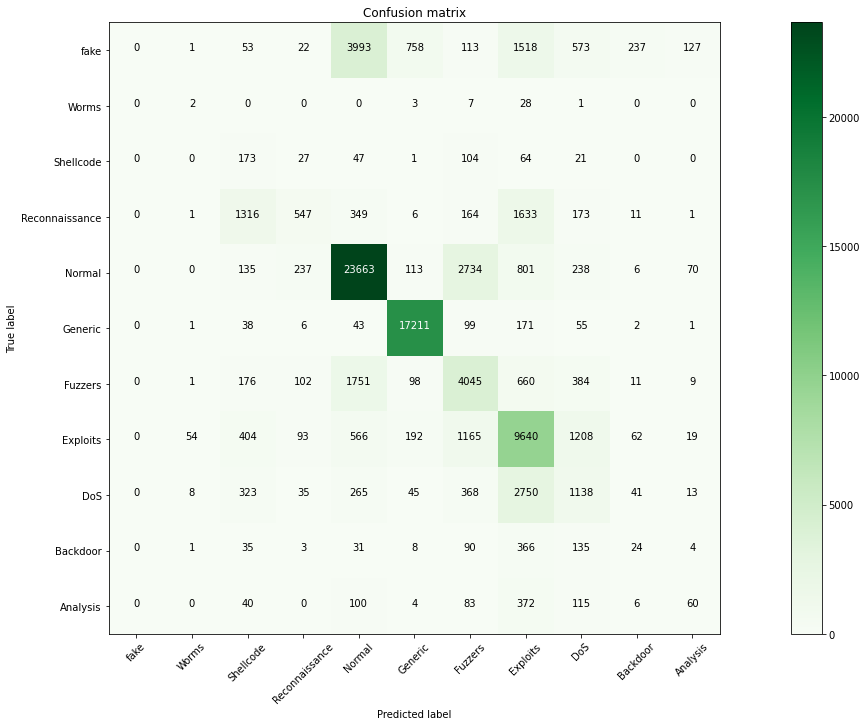

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[11,9,8,7,6,5,4,3,2,1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=['fake','Worms','Shellcode','Reconnaissance','Normal','Generic','Fuzzers','Exploits','DoS','Backdoor','Analysis'],normalize= False,  title='Confusion matrix')

In [19]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.20      0.08      0.11       780
           1       0.06      0.03      0.04       697
           2       0.28      0.23      0.25      4986
           3       0.54      0.72      0.61     13403
           4       0.45      0.56      0.50      7237
           5       0.93      0.98      0.95     17627
           6       0.77      0.85      0.80     27997
           7       0.51      0.13      0.21      4201
           8       0.06      0.40      0.11       437
           9       0.03      0.05      0.04        41
          11       0.00      0.00      0.00      7395

    accuracy                           0.67     84801
   macro avg       0.35      0.36      0.33     84801
weighted avg       0.62      0.67      0.63     84801



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **train label**

Epoch: 0, loss: 0.2384
Epoch: 50, loss: 0.0989
Epoch: 100, loss: 0.1040
Epoch: 150, loss: 0.1301
Epoch: 200, loss: 0.1092
Epoch: 250, loss: 0.0775
Epoch: 300, loss: 0.1062
Epoch: 350, loss: 0.0799
Epoch: 400, loss: 0.0914
Epoch: 450, loss: 0.0896
Epoch: 500, loss: 0.1047
Execution Time : 1286508.8750


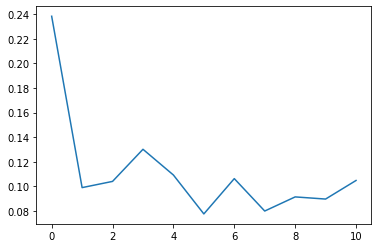

In [20]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

loss_plot = list()

for epoch in range(num_epoch+1):

    for batch_x, batch_y in train_label_dataloader:

        batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors
        
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer2.zero_grad()
        loss2 = loss_fn2(my_model_label(batch_x) , batch_y)
        loss2.backward() 
        optimizer2.step()

    if epoch % 50 == 0:
         print("Epoch: %d, loss: %.4f" % (epoch, loss2.item())) 
         loss_plot.append(loss2.item())         

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print("Execution Time : %.4f" % (start.elapsed_time(end)))

plt.plot(range(len(loss_plot)),np.asarray(loss_plot))
plt.show()

# **test label with fake dataset**

In [21]:
dataset_label = Fake_Real_DataSet_UNSWNB15_label("/content/drive/MyDrive/datasets/UNSW-NB15/fake_UNSW_NB15.csv","/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_label)*0.3)
number_of_train = len(dataset_label) - int(len(dataset_label)*0.3)
train_label ,test_label = random_split(dataset=dataset_label, lengths=[number_of_train,number_of_test])

test_label_dataloader = DataLoader(dataset=test_label ,batch_size=batch_size ,shuffle=True)

correct = 0
y_test, yhat = list(), list()

for batch_x, labl in test_label_dataloader:

    batch_x = torch.reshape(batch_x, (batch_x.shape[0], 1, batch_x.shape[1])) #RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_label(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)
    
    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i)

print("acc : %.2f" % (100.*correct / len(test_label)),end="")
print("%")

acc : 83.62%


Confusion matrix, without normalization
[[48274  8542]
 [ 5347 22638]]


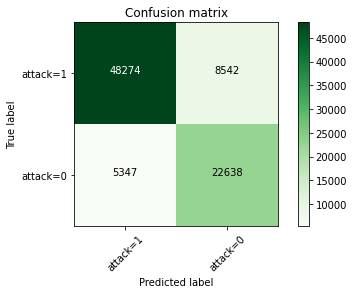

In [22]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['attack=1','attack=0'],normalize= False,  title='Confusion matrix')

In [23]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77     27985
           1       0.90      0.85      0.87     56816

    accuracy                           0.84     84801
   macro avg       0.81      0.83      0.82     84801
weighted avg       0.84      0.84      0.84     84801

